In [1]:
cd /home

/home


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toml
import glob
import os
pd.options.mode.chained_assignment = None  # default='warn'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_info_from_path(path, clf=False):
    factors = curr.split('/')
    info = {
        'ds_name': factors[6],
        'fold_n': int(factors[7].split('_')[-1]),
        'spc': int(factors[8].split('_')[-1]),
        'factors': factors[9] if clf else None
    }
    return info
def get_label(row, features_spec):
    label = []
    for f in features_spec:
        label.append(str(row[f]))
    label = '_'.join(label)
    return label

zero_alcock = {'20':0.27, '100':0.59}
zero_atlas = {'20':0.54, '100':0.56}

## Loading downstream data

In [92]:
model_paths = [
    './presentation/results/maogat/2024-06-02_04-10-22/',
    './presentation/results/maogat/2024-06-02_04-18-39/',
    './presentation/results/maogat/2024-06-02_04-19-29/',
]


model_paths = [
    './presentation/results/temp/2024-04-13_04-04-34/',
    './presentation/results/temp/2024-04-18_20-49-50/',
    './presentation/results/temp/2024-04-24_01-07-33/',
    './presentation/results/temp/2024-06-24_16-26-17/',
]

model_paths = [
    './presentation/results/zero/2024-04-24_16-13-23/',
    './presentation/results/zero/2024-04-29_05-06-25/'
]
features_spec = ['lr']

In [93]:
classification_stats = []
for m in model_paths:
    experiments = glob.glob(os.path.join(m, 'classification', '*', '*', '*','*'))
    for curr in experiments:
        info = get_info_from_path(curr, clf=True)
        with open(os.path.join(curr, 'config.toml'), 'r') as h:
            config = toml.load(h)
            spec = {k:config[k] for k in features_spec}

        with open(os.path.join(curr, 'test_metrics.toml'), 'r') as h:
            metrics = toml.load(h)
            for k in metrics:
                metrics[k] = float(metrics[k])

        combined = {**info, **spec, **metrics, **config}
        classification_stats.append(combined)

In [95]:
clf_stats = pd.DataFrame(classification_stats)

In [97]:
clf_stats_mean = clf_stats.groupby(features_spec+['ds_name', 'spc', 'factors'])['test_f1'].mean()
clf_stats_mean = clf_stats_mean.reset_index()

<Figure size 640x480 with 0 Axes>

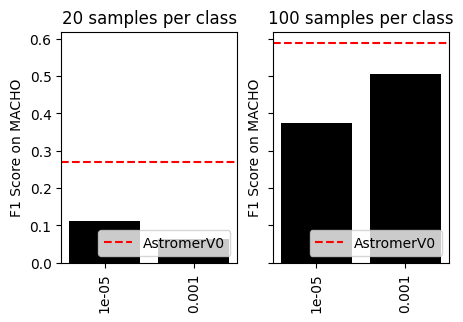

<Figure size 640x480 with 0 Axes>

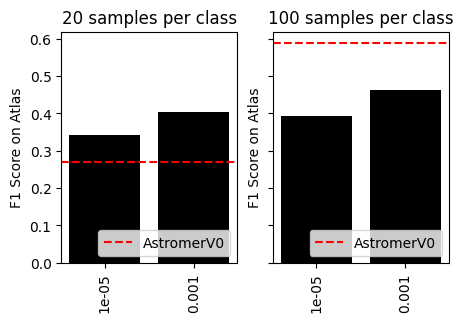

In [100]:
for ds, ds_name in zip(['alcock', 'atlas'], ['MACHO', 'Atlas']):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True, dpi=100)
    for i, spcc in enumerate([20, 100]):
        sel = clf_stats_mean[(clf_stats_mean['ds_name']==ds) & \
                             (clf_stats_mean['spc']==spcc) & \
                             (clf_stats_mean['factors']== 'avg_mlp')]
        sel['label'] = sel.apply(lambda x: get_label(x, features_spec), axis=1)

        axes[i].bar(range(len(sel.index)), sel['test_f1'], color='black')
        axes[i].set_xticks(range(len(sel.index)))
        axes[i].set_xticklabels(sel['label'], rotation=90)
        axes[i].set_title('{} samples per class'.format(spcc))
        axes[i].set_ylabel('F1 Score on {}'.format(ds_name))
        axes[i].axhline(zero_alcock[str(spcc)],color='red', ls='--', label='AstromerV0')
        axes[i].legend(loc='lower right')
    plt.show()